<a href="https://colab.research.google.com/github/dxvsh/LearningPytorch/blob/main/Week5/DLP_GA5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week 5 GA

In [2]:
!pip install transformers datasets torch > /dev/null

In [3]:
from datasets import get_dataset_config_names
from datasets import load_dataset
from pprint import pprint

In [5]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import numpy as np

 Use https://huggingface.co/datasets/facebook/voxpopuli Dataset for all the questions (except Q1 and Q2)

 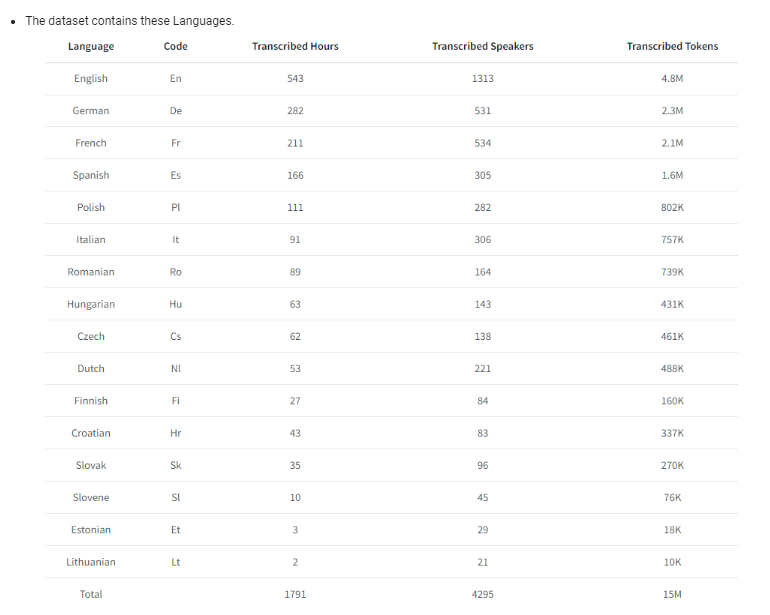

**Q1.** Which of the objective functions listed below are used for training Wav2vec2.0?


- [ ] Mean-squared error loss
- [ ] Cross entropy loss
- [x] Contrastive and Diversity loss
- [ ] Triplet loss


Source: [Wav2Vec2 paper](https://arxiv.org/pdf/2006.11477)

**Q2.** After applying a one-dimensional Maxpool operation with a kernel size of 3 and a stride of 1 to an input of size 513, what will be the resulting output size?

**A.** Recall,

$$ W_2 = \frac{W_1 - F + 2P}{S} + 1$$

For pooling operation, we don't use padding, so $P=0$

$$ W_2 = \frac{513 - 3}{1} + 1$$

So, $W_2 = 511$

Resulting output size after Maxpool operation is $511$

**Q3.** Load a streaming dataset of Lithuanian audio samples from the "facebook/voxpopuli" dataset and answer the questions 3, 4, and 5.

Load the dataset with the train split only.

What is the gender of the 20th Lithuvanian data point in the VoxPopuli dataset?

- [ ] Male
- [x] Female

In [7]:
pprint(get_dataset_config_names('facebook/voxpopuli'), compact=True)

['en', 'de', 'fr', 'es', 'pl', 'it', 'ro', 'hu', 'cs', 'nl', 'fi', 'hr', 'sk',
 'sl', 'et', 'lt', 'en_accented', 'multilang']


The config code for Lithuanian is `lt`

In [8]:
dataset_lt = load_dataset('facebook/voxpopuli', 'lt', split='train', streaming=True)

In [9]:
for i, example in enumerate(dataset_lt):
    if i == 20:
        pprint(example)
        break

{'accent': 'None',
 'audio': {'array': array([-0.0144043 ,  0.0043335 ,  0.00134277, ..., -0.04492188,
       -0.03408813, -0.03613281]),
           'path': 'train_part_0/20140113-0900-PLENARY-20-lt_20140113-22:13:25_3.wav',
           'sampling_rate': 16000},
 'audio_id': '20140113-0900-PLENARY-20-lt_20140113-22:13:25_3',
 'gender': 'female',
 'is_gold_transcript': True,
 'language': 15,
 'normalized_text': 'deja skirtingų šalių praktikoje ši įmonių valdymo '
                    'priemonė vis dar nėra tolygiai išvystyta todėl europos '
                    'sąjungos lygiu būtina ir prasminga šia tema diskutuoti '
                    'ieškoti ir siūlyti būdus kaip situaciją valstybėse narėse '
                    'keisti kokie modeliai būtų patys priimtiniausi.',
 'raw_text': 'Deja, skirtingų šalių praktikoje ši įmonių valdymo priemonė vis '
             'dar nėra tolygiai išvystyta, todėl Europos Sąjungos lygiu būtina '
             'ir prasminga šia tema diskutuoti, ieškoti ir siūlyti

In [10]:
example['gender']

'female'

**Q4.** What is the speaker-id of the 20th Lithuvanian data point in the VoxPopuli dataset?

In [11]:
example['speaker_id']

'96681'

**Q5.** How many data points are there in the Lithuvanian data in the VoxPopuli dataset?

**A.** According to the HF page of the VoxPopuli dataset, the Lithuanian subset has 501 rows: **456** in train, 3 in val, 42 in test.

We only need to report the datapoints in the train split, so the answer is **456**.

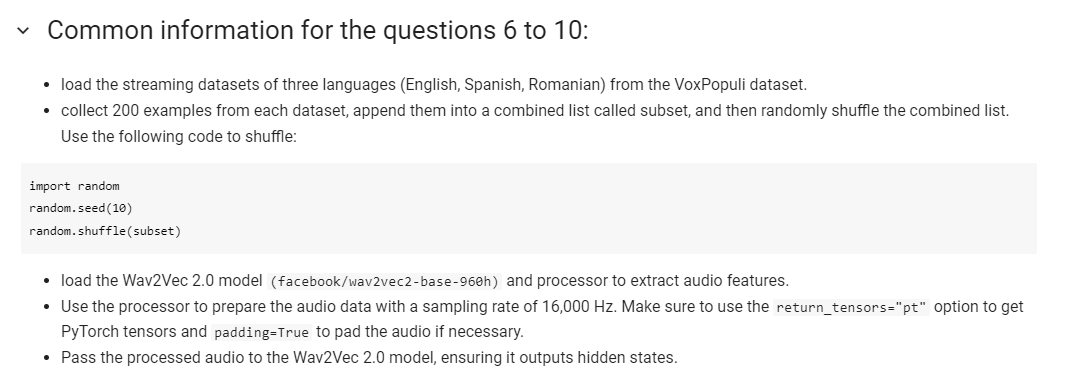

**Q6.** Combine the hidden states from the 10th and 8th layers, average them along the first dimension, and report the final output shape. Enter the answer as an integer.

In [12]:
languages = ['en', 'es', 'ro']
subset = []

for lang in languages:
    # Load dataset
    dataset = load_dataset("facebook/voxpopuli", lang, split="train", streaming=True)

    for i, example in enumerate(dataset):
        if i == 200:
            break
        subset.append(example)

# Shuffle the combined list
import random
random.seed(10)
random.shuffle(subset)

In [13]:
len(subset)

600

We got 200 samples each from the English, Spanish and Romanian dataset and combined them together in a list and shuffled it

In [15]:
# Load the Wav2Vec2 model and processor
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model.config

In [16]:
model.config.num_hidden_layers

12

The Wav2Vec2 model has 12 hidden layers

In [17]:
model.config.hidden_size

768

So the size of each hidden layer is 768 which means that each of the hidden layers has 768 neurons.

Now if we take states of the 8th and 10th layers (both of which are 768 in size), and average them, the output shape of the averaged layer will still remain **768**.

But lets try this out on a sample and make sure this is the truth:

In [18]:
def extract_wav2vec_features(sample):
    """Takes an audio sample as input and returns the extracted features using the model"""

    inputs = processor(sample['audio']['array'], sampling_rate=16000, return_tensors='pt', padding=True)

    # Get model outputs with hidden states
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract hidden states for layers 8 and 10
    hidden_states = outputs.hidden_states
    layer_8 = hidden_states[8]
    layer_10 = hidden_states[10]

    # Stack/combine these layers
    combined_layers = torch.stack([layer_8, layer_10])

    # Average the two layers along the first dimension (dim=0)
    averaged_features = torch.mean(combined_layers, dim=0)

    # Return the averaged features and the label
    return {'features': averaged_features.squeeze().mean(dim=0).numpy(), 'label': sample['language']}

In [19]:
sample = subset[0] # lets try extracting the features from this sample and see if the feature size is indeed 768
#extract_wav2vec_features(sample)

In [20]:
extract_wav2vec_features(sample)['features'].shape

(768,)

So even if we use the average of the 8th and 10th hidden layer for generating the features of the audio, we'll still get **768** as the output shape.

**Q7.**

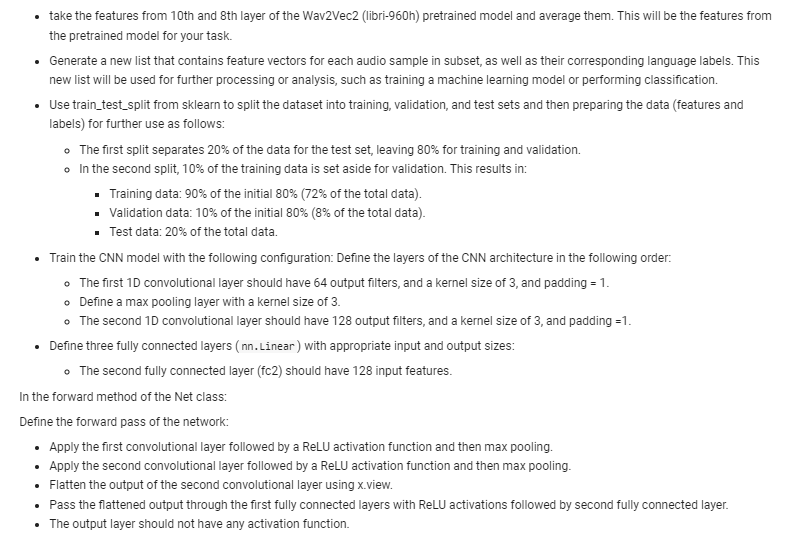

What is the shape of the output after the first convolution layer with kernel size 3 and padding 1 when out channels are 64 and in channels are 1 with input shape of 768 for the train data?


- [ ] (120,64,768)
- [x] (432,64,768)
- [ ] (432,128,512)


**A.** After the first convolution, the shape of a datapoint will become (64, 768) because 64 filters are applied and since there are 432 samples in the train split, it becomes **(432, 64, 768)**

Lets first extract the features using our function for all the samples in the dataset (took about 40 mins to run):

In [21]:
subset_with_features = [extract_wav2vec_features(sample) for sample in subset]

In [22]:
len(subset_with_features)

600

In [23]:
from sklearn.model_selection import train_test_split

# split the dataset into train, and test sets
train_data, test_data = train_test_split(subset_with_features, test_size=0.2, random_state=42)

# take the train_data gotten from above and split it further into train and val sets
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# now our train set has 432 samples, the test set has 120 samples and the
# validation set has 48 samples

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # flatten the output after the convolution before passing it to the fully connected layer
        self.fc1 = nn.Linear(128 * (input_length // 9), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # define the forward pass computation
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=3)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=3)
        x = x.view(x.size(0), -1) # flattens the data to be fed into the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
# Extract features and labels from the data
def prepare_data(data):
    features = [sample['features'] for sample in data]
    labels = [sample['label'] for sample in data]
    return torch.tensor(features), torch.tensor(labels)

train_features, train_labels = prepare_data(train_data)
val_features, val_labels = prepare_data(val_data)
test_features, test_labels = prepare_data(test_data)

<ipython-input-25-5cda3cd14d15>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(features), torch.tensor(labels)


In [26]:
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)

Train features shape: torch.Size([432, 768])
Train labels shape: torch.Size([432])


**Q8.** What is parameter count of the first convolution layer of the CNN model?

**A.** The first layer uses a **3 x 1** filter, and there are 64 such filters so the number of parameters in the first conv layer is 64*3.

In [27]:
64*3

192

**Q9.** What is the total parameter count of the CNN model?

Currently, English has language id 0, Spanish has 3 and Romanian has 6. Instead of 0,3,6, lets map them to 0,1,2.

The cross entropy loss function expects the target labels to be integers in the range `[0, num_classes-1]` and in our case `num_classes` is 3, so the target labels should be: `[0, 1, 2]`  instead of `[0, 3, 6]`. Otherwise, we'll get an `IndexError` saying `Target 6 is out of bounds`.

In [28]:
# Assuming train_features and val_features are already loaded
# And they have the shape [num_samples, sequence_length]

input_length = train_features.shape[1] # get the sequence length (768 in this case)

# Assuming we have 3 languages in the dataset, and the original labels are 6, 0, and 3
label_mapping = {6: 0, 0: 1, 3: 2}

# Now Romanian has id : 0
# English has id : 1
# Spanish has id : 2

# Apply the label mapping
train_labels = train_labels.apply_(lambda x: label_mapping[x])
val_labels = val_labels.apply_(lambda x: label_mapping[x])
test_labels = test_labels.apply_(lambda x: label_mapping[x])

# Verify the mapping
unique_train_labels = torch.unique(train_labels)
unique_val_labels = torch.unique(val_labels)
unique_test_labels = torch.unique(test_labels)

print("Unique labels in train_labels:", unique_train_labels)
print("Unique labels in val_labels:", unique_val_labels)
print("Unique labels in test_labels:", unique_test_labels)

Unique labels in train_labels: tensor([0, 1, 2])
Unique labels in val_labels: tensor([0, 1, 2])
Unique labels in test_labels: tensor([0, 1, 2])


Initialize the model and find out the number of parameters:

In [29]:
model = CNNModel(num_classes=3)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 1418115


**Q10.** Train the model for 50 epochs and set seed to 10. Enter the value of test accuracy in percentage.

In [30]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
torch.manual_seed(10)
for epoch in range(num_epochs):
    # Training
    # Set the model to training mode
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features.unsqueeze(1).float()) #inserts a new dimension at pos 1, to represent a channel dimension
    loss = loss_fn(outputs, train_labels)
    loss.backward()
    optimizer.step()

    # Validation
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad(): # disable gradient calculations, we're only interested in inference during eval
        val_outputs = model(val_features.unsqueeze(1).float())
        val_loss = loss_fn(val_outputs, val_labels)

    # print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")


Epoch 10/50, Training Loss: 1.0526446104049683, Validation Loss: 1.0583922863006592
Epoch 20/50, Training Loss: 0.7570023536682129, Validation Loss: 0.7772448658943176
Epoch 30/50, Training Loss: 0.5061650276184082, Validation Loss: 0.5482270121574402
Epoch 40/50, Training Loss: 0.4345667362213135, Validation Loss: 0.48269012570381165
Epoch 50/50, Training Loss: 0.36302661895751953, Validation Loss: 0.42708659172058105


In [31]:
from sklearn.metrics import accuracy_score

# Ensure your model is in evaluation mode
model.eval()

# Disable gradient computaion
with torch.no_grad():
    # Forward pass to get predictions
    test_outputs = model(test_features.unsqueeze(1).float())

    # Get the predicted class labels
    # torch.max gives both the max val and its index (the label in this case), we're only interested in the label
    _, predicted = torch.max(test_outputs, 1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels.numpy(), predicted.numpy())

# Print the test accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 90.83%
